In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.pyplot import figure
import xgboost
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


In [2]:
# Import data on round spending (Economy)

dfeco = pd.read_csv("economy_update.csv")


Columns (0,4,5,6,8,9,456,457,458,459,460,461,462,463) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
# Data cleaning of the latter

dfeco = dfeco.replace('#DIV/0!',0)
dfeco[['T1_HVHV','T1_LVLV','T1_HVLV','T1_LVHV','T2_HVHV','T2_LVLV','T2_HVLV','T2_LVHV']] = dfeco[['T1_HVHV','T1_LVLV','T1_HVLV','T1_LVHV','T2_HVHV','T2_LVLV','T2_HVLV','T2_LVHV']].fillna(0)
dfeco[['T1_HVHV','T1_LVLV','T1_HVLV','T1_LVHV','T2_HVHV','T2_LVLV','T2_HVLV','T2_LVHV']] = dfeco[['T1_HVHV','T1_LVLV','T1_HVLV','T1_LVHV','T2_HVHV','T2_LVLV','T2_HVLV','T2_LVHV']].astype(float)


In [4]:
# Import data on players statistics

dfplay = pd.read_csv("players.csv")


In [5]:
# Data cleaning

dfeco = dfeco[dfeco['best_of']!="o"]
dfeco['best_of'] = dfeco['best_of'].astype(float)
dfeco = dfeco[(dfeco['best_of']==1) & (dfeco['30_t1'].isnull())]
dfeco.key = dfeco.key.astype(np.int64)


In [6]:
# Obtain teams' averages on streak losses and spending proportions

dfecoteam = dfeco[['team_1',
    't1_p2','t1_p3','t1_p4','t1_p5p',
    'T1_HVHV','T1_LVLV','T1_HVLV','T1_LVHV']].groupby(['team_1'], as_index=False).mean()

dfecoteam.columns = ['Teamavg',
    't1_2-','t1_3-','t1_4-','t1_5plus-',
    't1_hvhv-','t1_lvlv-','t1_hvlv-','t1_lvhv-']


In [7]:
# Obtain players' statistics averages

dfplay = dfplay[dfplay['best_of']==1]

dfplay = dfplay[['key','team',
 'kills',
 'assists',
 'deaths',
 'hs',
 'flash_assists',
 'kast',
 'kddiff',
 'adr',
 'fkdiff',
 'rating']].groupby(['key','team'], as_index=False).mean()


In [8]:
# Data cleaning

dfplay['key'] = dfplay["key"].astype(str) + dfplay["team"].astype(str)
dfeco['key1'] = dfeco["key"].astype(str) + dfeco["team_1"].astype(str)
dfeco['key2'] = dfeco["key"].astype(str) + dfeco["team_2"].astype(str)


In [9]:
# Merge data

df = dfeco.merge(dfplay, left_on='key1', right_on='key', how='left')
df22 = df.merge(dfplay, left_on='key2', right_on='key', how='left')
df23 = df22.merge(dfecoteam, left_on='team_1', right_on='Teamavg', how='left')
df24 = df23.merge(dfecoteam, left_on='team_2', right_on='Teamavg', how='left')


In [10]:
# Data cleaning

df25=df24[df24.kills_y.notnull()]
df26=df25[df25.Teamavg_y.notnull()]


In [11]:
# Select wanted columns

df_ = df26[df.kills.notnull()][['key','_map','t1_start','t2_start',
    'scoret1','scoret2',
    'team_x','kills_x','assists_x','deaths_x','hs_x','kast_x','kddiff_x','adr_x','fkdiff_x','rating_x',
    'team_y','kills_y','assists_y','deaths_y','hs_y','kast_y','kddiff_y','adr_y','fkdiff_y','rating_y',
   't1_2-_x',
 't1_3-_x',
 't1_4-_x',
 't1_5plus-_x',
 't1_hvhv-_x',
 't1_lvlv-_x',
 't1_hvlv-_x',
 't1_lvhv-_x',
 't1_2-_y',
 't1_3-_y',
 't1_4-_y',
 't1_5plus-_y',
 't1_hvhv-_y',
 't1_lvlv-_y',
 't1_hvlv-_y',
 't1_lvhv-_y']]


Boolean Series key will be reindexed to match DataFrame index.


In [12]:
# Determine winner

df_.loc[df_['scoret1'] == 16, 'target'] = 0
df_.loc[df_['scoret1'] != 16, 'target'] = 1


In [13]:
# Select wanted columns

df_train = df_[['key','_map','t1_start','t2_start',
    'team_x',
    'team_y',
   't1_2-_x',
 't1_3-_x',
 't1_4-_x',
 't1_5plus-_x',
 't1_hvhv-_x',
 't1_lvlv-_x',
 't1_hvlv-_x',
 't1_lvhv-_x',
 't1_2-_y',
 't1_3-_y',
 't1_4-_y',
 't1_5plus-_y',
 't1_hvhv-_y',
 't1_lvlv-_y',
 't1_hvlv-_y',
 't1_lvhv-_y',
 'target']]


In [14]:
# Rename columns

df_train.columns = ['key','_map','t1_start','t2_start',
 'team_1',
 'team_2',
 'T1_2L',
 'T1_3L',
 'T1_4L',
 'T1_5plus',
 'T1_HV-HV',
 'T1_LV-LV',
 'T1_HV-LV',
 'T1_LV-HV',
 'T2_2L',
 'T2_3L',
 'T2_4L',
 'T2_5plus',
 'T2_HV-HV',
 'T2_LV-LV',
 'T2_HV-LV',
 'T2_LV-HV',
 'target']


In [15]:
# Define INPUT for XGBoost

var_colums = [c for c in df_train.columns if c not in ['key','team_1','team_2','_map','t1_start','t2_start','target']]
X = df_train.loc[:, var_colums]
y = df_train.loc[:, 'target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((6438, 16), (2760, 16), (6438,), (2760,))

In [16]:
# Hyperparameters selection and model training

model_xgboost = xgboost.XGBClassifier(learning_rate=0.1,
                                      max_depth=5,
                                      n_estimators=5000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      verbosity=1)

eval_set = [(X_valid, y_valid)]

model_xgboost.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)


[0]	validation_0-auc:0.69219
[1]	validation_0-auc:0.69622
[2]	validation_0-auc:0.71011
[3]	validation_0-auc:0.71524
[4]	validation_0-auc:0.71992
[5]	validation_0-auc:0.72186
[6]	validation_0-auc:0.72251
[7]	validation_0-auc:0.72745


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[8]	validation_0-auc:0.72832
[9]	validation_0-auc:0.72916
[10]	validation_0-auc:0.72988
[11]	validation_0-auc:0.72963
[12]	validation_0-auc:0.72968
[13]	validation_0-auc:0.72916
[14]	validation_0-auc:0.73001
[15]	validation_0-auc:0.72992
[16]	validation_0-auc:0.73047
[17]	validation_0-auc:0.73197
[18]	validation_0-auc:0.73341
[19]	validation_0-auc:0.73314
[20]	validation_0-auc:0.73292
[21]	validation_0-auc:0.73256
[22]	validation_0-auc:0.73318
[23]	validation_0-auc:0.73473
[24]	validation_0-auc:0.73441
[25]	validation_0-auc:0.73456
[26]	validation_0-auc:0.73533
[27]	validation_0-auc:0.73581
[28]	validation_0-auc:0.73602
[29]	validation_0-auc:0.73641
[30]	validation_0-auc:0.73644
[31]	validation_0-auc:0.73727
[32]	validation_0-auc:0.73729
[33]	validation_0-auc:0.73711
[34]	validation_0-auc:0.73770
[35]	validation_0-auc:0.73725
[36]	validation_0-auc:0.73677
[37]	validation_0-auc:0.73695
[38]	validation_0-auc:0.73726
[39]	validation_0-auc:0.73692
[40]	validation_0-auc:0.73653
[41]	validat

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


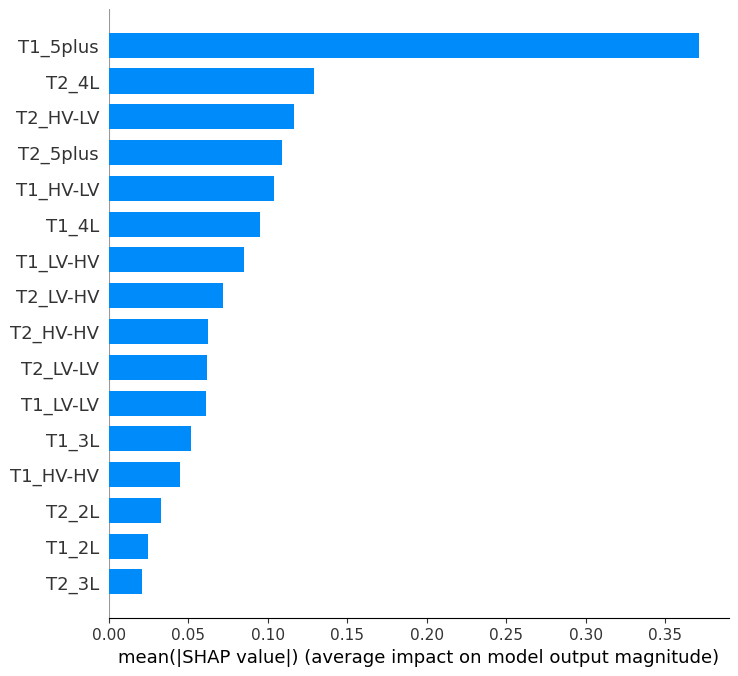

In [17]:
# SHAP Feature Importance

explainer = shap.TreeExplainer(model_xgboost)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")


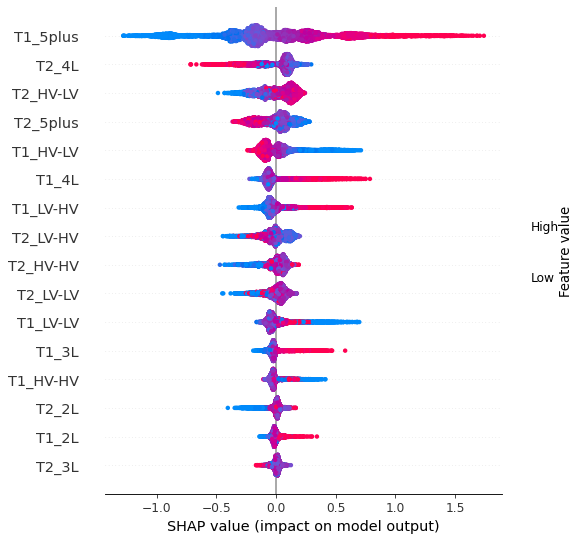

In [18]:
# SHAP Summary Plot

figure(figsize=(15, 10), dpi=80)
shap.summary_plot(shap_values, X)


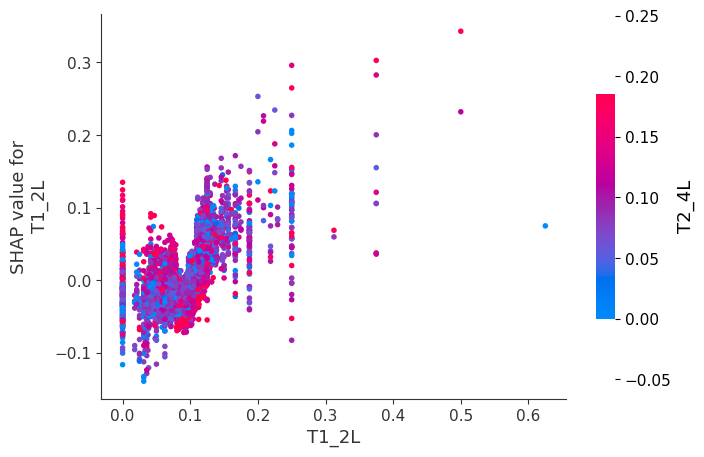

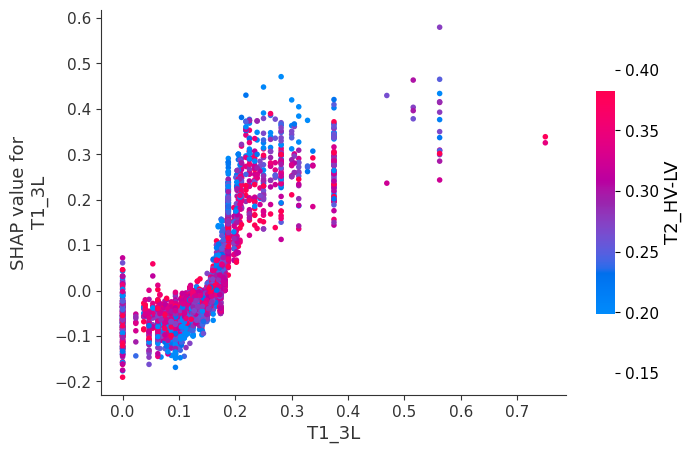

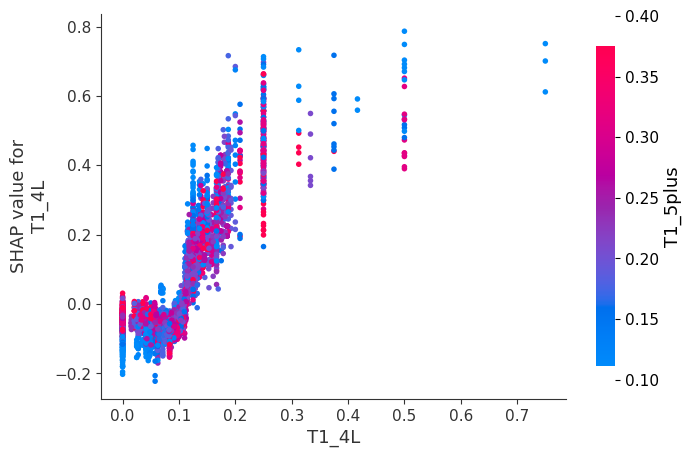

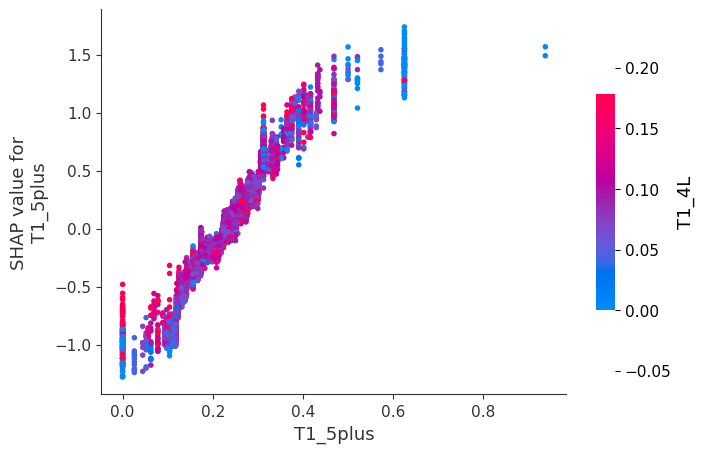

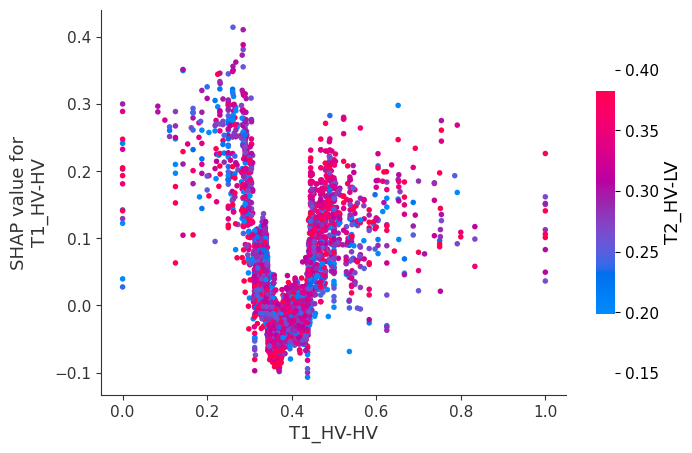

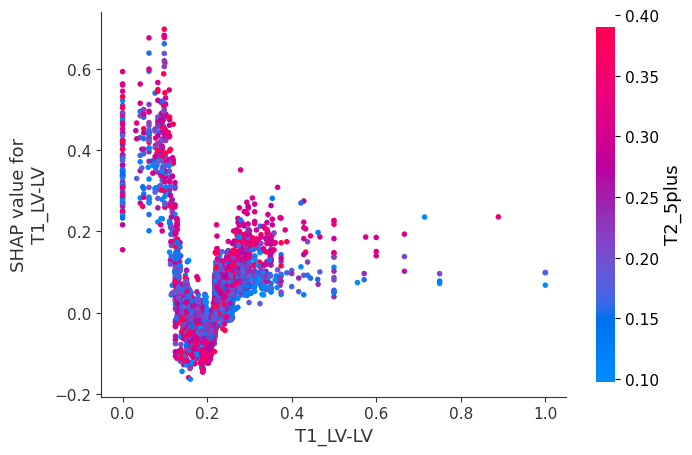

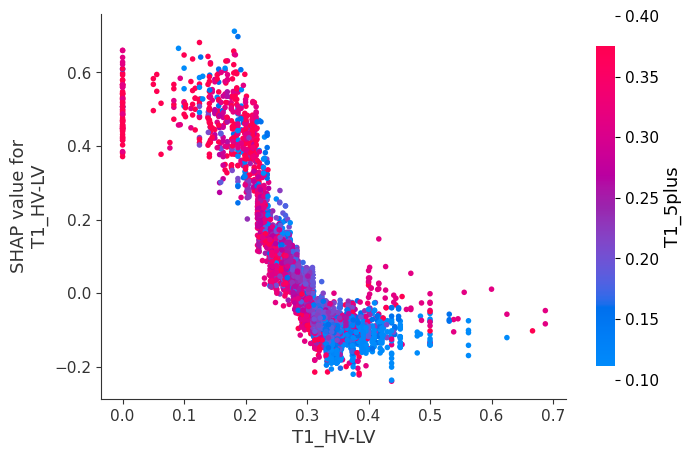

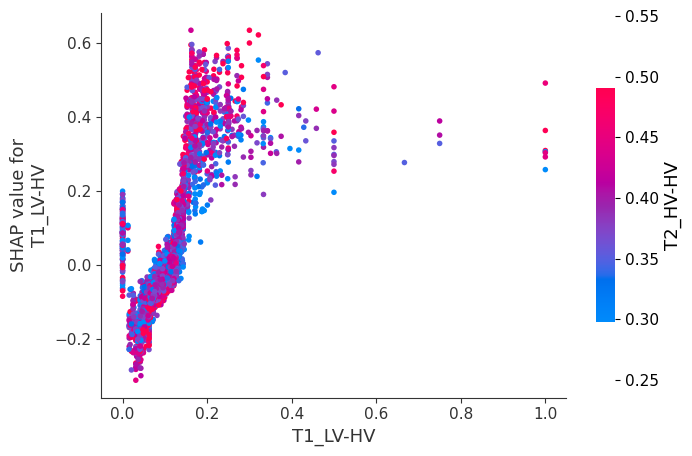

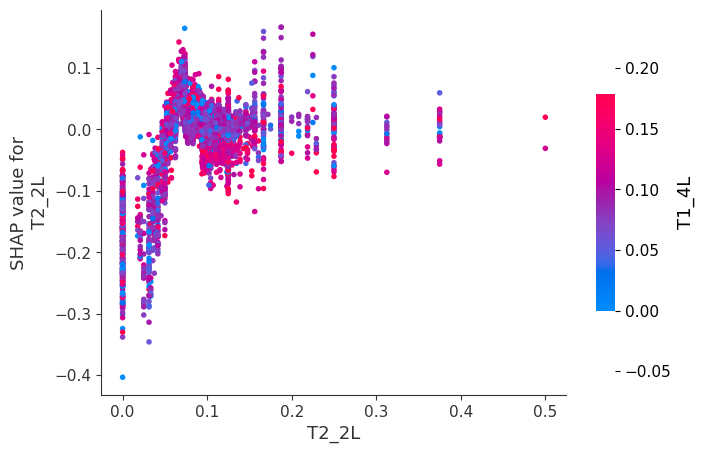

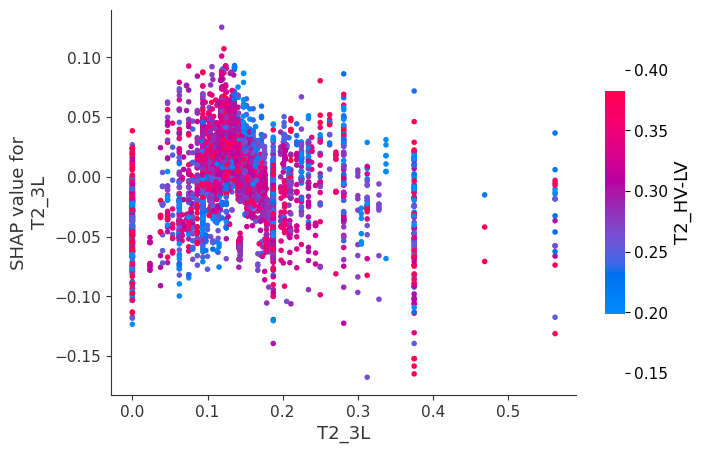

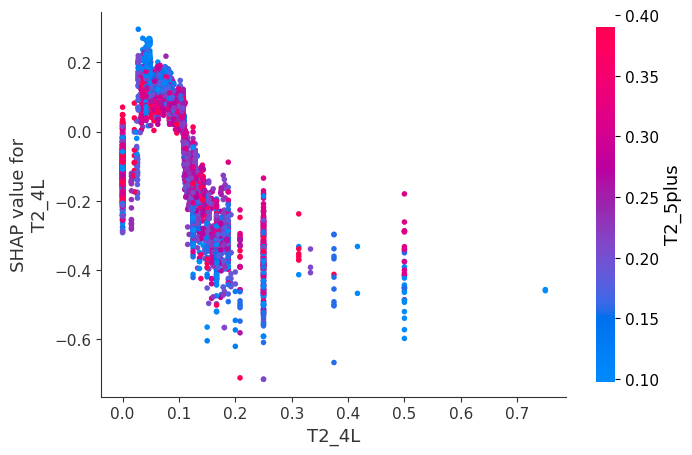

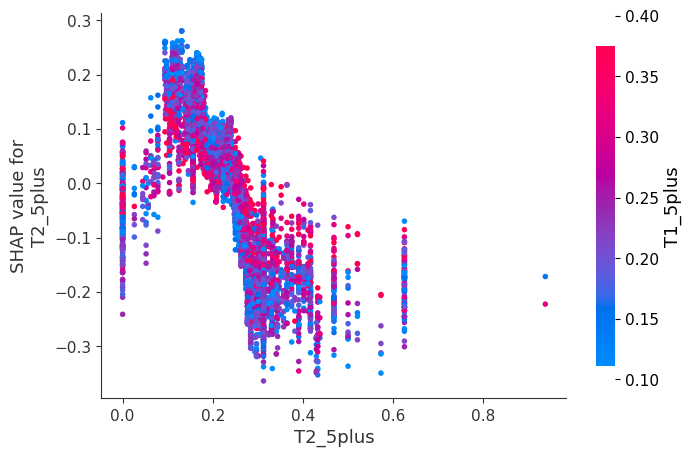

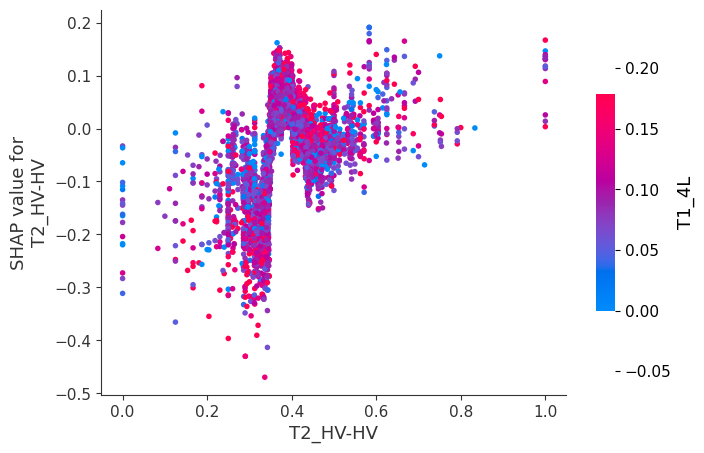

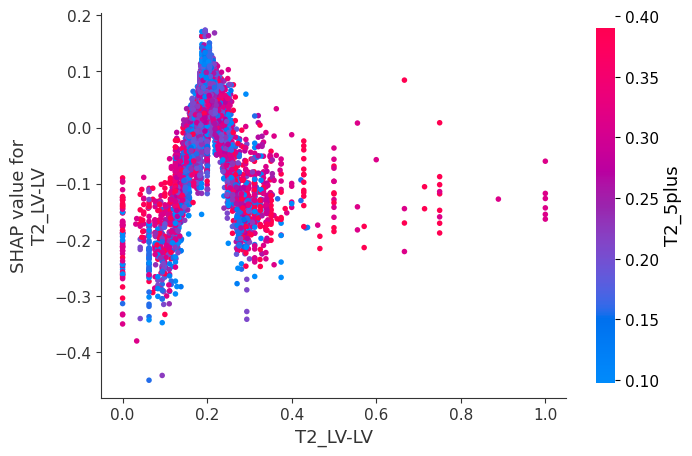

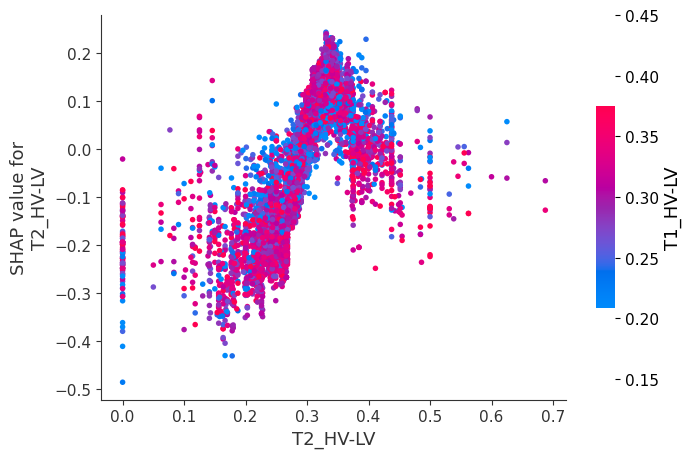

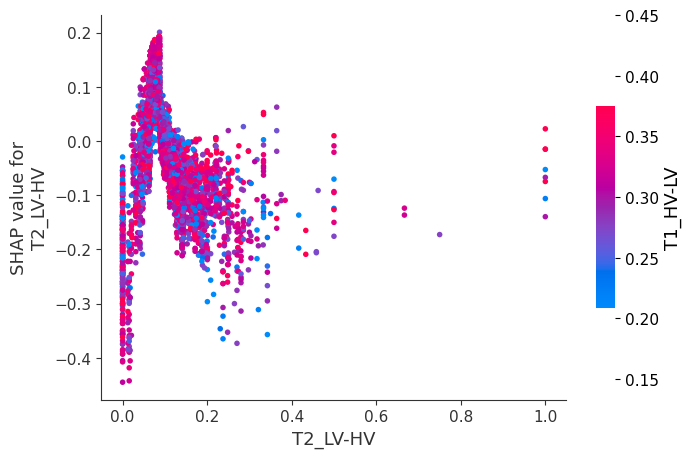

In [19]:
# SHAP Dependence Plots

for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X)
    

In [20]:
# AUC Values

y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost.predict_proba(X_valid)[:,1]

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred)))


AUC Train: 0.7988
AUC Valid: 0.7377
